### Import modules

In [1]:
import sys
import os
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import ts_aggregation_by, series_train_test_split, plot_forecasting_eval, plot_forecasting_series

#### Load data

In [2]:
data_path = os.path.abspath(os.path.join('..','..', 'data/f_s_forecast_ny_arrests.csv'))

def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col="Date",
        sep=";",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

data = load_data(data_path)
file_tag = "ARREST"
target = "Manhattan"

data = data[[target]]

### Preparation

In [3]:
def data_preparation(data):
    # Missing value 
    data: DataFrame = data.dropna(how="any", inplace=False)    

    # Scaling
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
    data = DataFrame(transf.transform(data), index=data.index)
    series: Series = data

    # Aggregation
    agg_df_week: DataFrame = ts_aggregation_by(series, gran_level="W", agg_func="sum")
    agg_df_month: DataFrame = ts_aggregation_by(series, gran_level="M", agg_func="sum")
    agg_df_quarter: DataFrame = ts_aggregation_by(series, gran_level="Q", agg_func="sum")

    # Smoothing
    WIN_SIZE = 25
    ss_smooth: Series = series.rolling(window=WIN_SIZE).mean()
    ss_smooth = ss_smooth.dropna()

    # Differentiation
    ss_diff: Series = ss_smooth.diff()
    ss_diff = ss_diff.dropna()
    ss_diff: Series = ss_diff.diff()
    ss_diff = ss_diff.dropna()

    # Train/test split
    train, test = series_train_test_split(ss_diff)

    return train, test
    
    
train, test = data_preparation(data)

print(train)
print(test)

Date
2006-01-27   -0.000416
2006-01-28   -0.011854
2006-01-29   -0.010399
2006-01-30   -0.000069
2006-01-31    0.004159
                ...   
2020-05-24   -0.001386
2020-05-25    0.002357
2020-05-26    0.001872
2020-05-27    0.005061
2020-05-28   -0.001802
Name: 0, Length: 5236, dtype: float64
Date
2020-05-29   -0.004159
2020-05-30    0.003189
2020-05-31   -0.001872
2020-06-01    0.032444
2020-06-02   -0.019827
                ...   
2021-12-27    0.002634
2021-12-28    0.001040
2021-12-29    0.003466
2021-12-30   -0.001317
2021-12-31   -0.000139
Name: 0, Length: 582, dtype: float64


#### Linear Regression

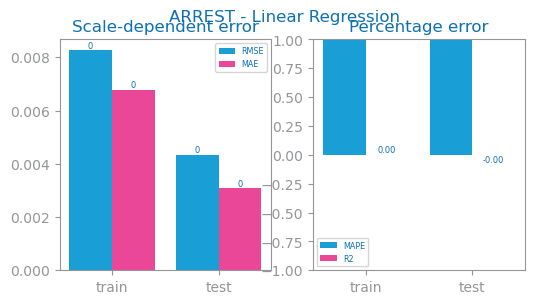

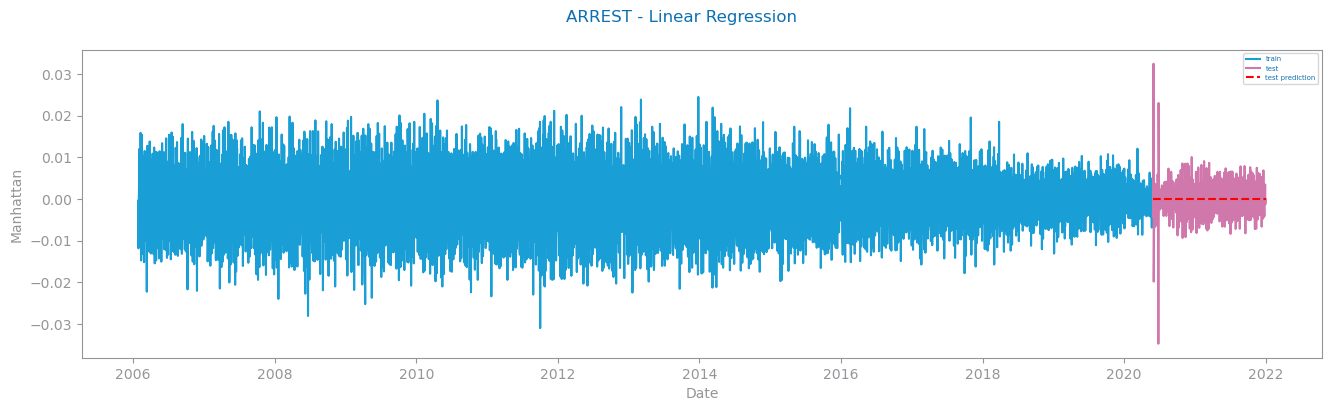

In [4]:
trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(train)+len(test)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}_linear_regression_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel="Date",
    ylabel=target,
)
savefig(f"images/{file_tag}_linear_regression_forecast.png")